In [11]:
pip install "datasets==3.5.1"

In [12]:
from datasets import load_dataset

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


================ ETHICS ================

--- Layer 27/28 ---
[Axis sanity] Val Acc=0.609 CE=1.692 | Test Acc=0.688 CE=1.201
[Explicit] N=120  Cohen d=2.09


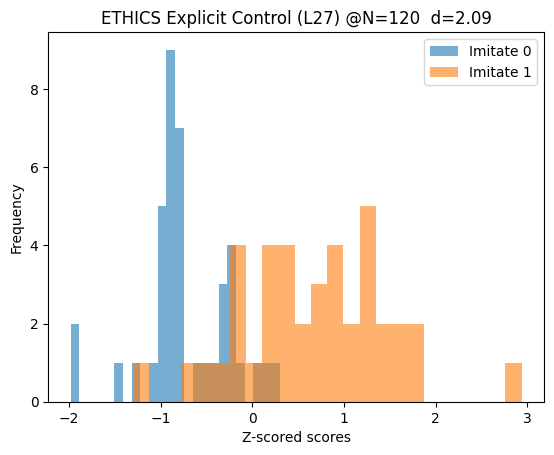

[Implicit] N=120  Cohen d=0.17


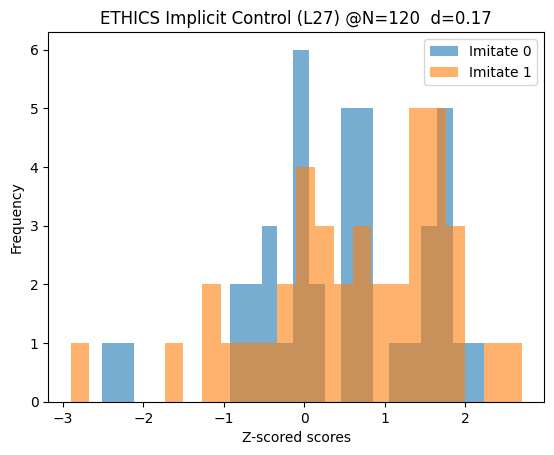


================ BoolQ ================

--- Layer 27/28 ---
[Axis sanity] Val Acc=0.672 CE=0.941 | Test Acc=0.637 CE=0.998
[Explicit] N=120  Cohen d=-0.27


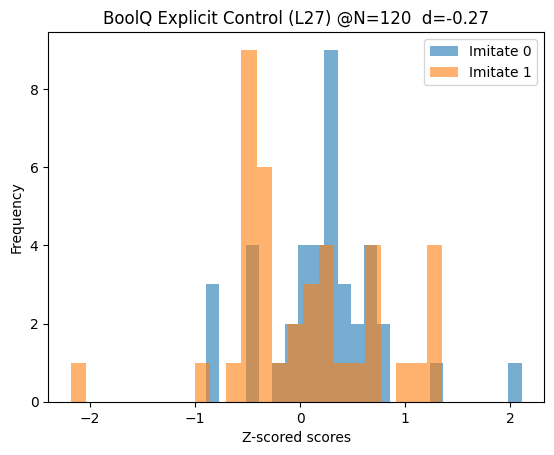

[Implicit] N=120  Cohen d=0.06


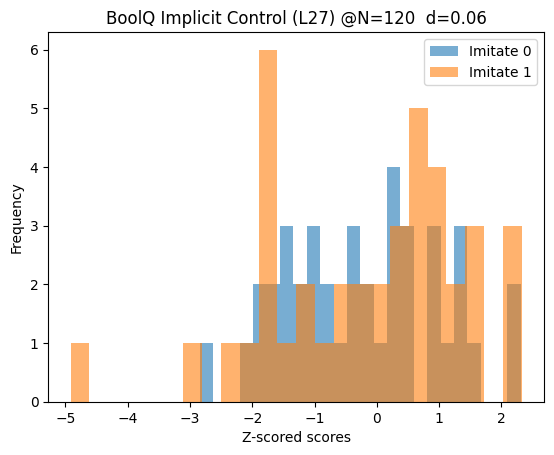

In [13]:
# ========================= Metacognitive Reporting + Control (Appendix-aligned, single-layer) =========================
# - Runs ONE target layer by default (axis, θ, labels, reporting, control ALL at that layer)
# - Reporting: flat prompt (no chat) -> logits at "[Score:{" ; y_true from prompt-position hidden state at that token
# - Control: chat prompts (explicit + implicit), 2x2-style (same demos+labels, different target labels)
# - Implicit control uses the SAME base sentences across all four conditions
# - Histograms plot Z-SCORED projections so x-axis ~ [-2, 2] like the paper
# - Held-out pool = (VAL + TEST); demos/query ONLY from pool
# ====================================================================================================================================

import math, random, numpy as np, torch, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ---------------------------- Config ----------------------------
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# Probing / generation
MAX_LENGTH   = 300
BATCH_SIZE   = 32
GEN_TOKENS   = 100
GEN_TEMP     = 0.5
GEN_TOP_P    = 0.9

# Splits (per-class for non-ETHICS)
TRAIN_PC, VAL_PC, TEST_PC = 128, 64, 128

# Reporting curve
EXAMPLE_COUNTS = [0,2,4,8,16,32,64]
TRIALS_PER_N   = 20

# ETHICS tiny split (balanced; half train / half pool)
ETHICS_TOTAL   = 256

# Control
K_DEMOS             = 8
CONTROL_M_PER_COND  = 10
CONTROL_REPEATS     = 2
CONTROL_N_SWEEP     = [2,4,8,16,32,60,120]

# Layer (single target layer only)
TARGET_LAYER   = -1   # choose a single layer (e.g., -2 or an absolute int index)

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.bfloat16 if (torch.cuda.is_available() and hasattr(torch, "bfloat16")) else torch.float16

# ---------------------------- Model ----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=dtype if device == "cuda" else torch.float32,
    low_cpu_mem_usage=True,
    output_hidden_states=True
).to(device)
model.eval()

NUM_LAYERS = getattr(model.config, "num_hidden_layers", 32)
MAX_CONTEXT_TOKENS = getattr(model.config, "max_position_embeddings", 4096)

# Resolve TARGET_LAYER to absolute
if TARGET_LAYER < 0:
    LAYER = NUM_LAYERS + TARGET_LAYER  # e.g., -2 -> last-1
else:
    LAYER = TARGET_LAYER
LAYER = max(0, min(NUM_LAYERS, LAYER))

# ---------------------------- Utils ----------------------------
def sigmoid(x): return 1/(1+np.exp(-x))

def truncate_tail(text, max_ctx_tokens, reserve_new=0):
    ids = tokenizer(text, return_tensors="pt", add_special_tokens=False)["input_ids"][0]
    limit = max_ctx_tokens - reserve_new
    if limit <= 0: limit = max_ctx_tokens
    if ids.shape[0] <= limit: return text
    return tokenizer.decode(ids[-limit:], skip_special_tokens=True)

# ---- projection helpers (raw vs z-scored) ----
def _proj_raw(vec, axis):
    return float(vec @ axis)

def _proj_z(vec, axis, mu, sigma):
    return (float(vec @ axis) - mu) / (sigma + 1e-12)

# ---------------------------- Embeddings (batched + per-layer cache) ----------------------------
_EMBED_CACHE = {}  # cache[(text, layer_index)] = np.ndarray(dim)

@torch.inference_mode()
def embed_layer(texts, layer_index:int):
    """Mean-pooled residual stream at a specific layer index for each text."""
    out_vecs, missing = [], []
    for t in texts:
        key = (t, layer_index)
        if key in _EMBED_CACHE: out_vecs.append(_EMBED_CACHE[key])
        else: out_vecs.append(None); missing.append(t)

    for i in range(0, len(missing), BATCH_SIZE):
        batch = missing[i:i+BATCH_SIZE]
        tok = tokenizer(batch, return_tensors="pt",
                        truncation=True, padding=True,
                        max_length=MAX_LENGTH).to(device)
        outputs = model(**tok)
        h = outputs.hidden_states[layer_index]              # [B, T, D]
        v = h.mean(dim=1).to(torch.float32).cpu().numpy()   # [B, D]
        for t, vec in zip(batch, v):
            _EMBED_CACHE[(t, layer_index)] = vec

    res = []
    for t, maybe in zip(texts, out_vecs):
        res.append(_EMBED_CACHE[(t, layer_index)] if maybe is None else maybe)
    return np.vstack(res)  # [N, D]

@torch.inference_mode()
def embed_layer_last_token(texts, layer_index:int):
    """
    Take the hidden state at the *last non-pad token* for each text, at the chosen layer.
    Used for control tasks to approximate the 'neural score' of the final assistant turn.
    """
    out = []
    for i in range(0, len(texts), BATCH_SIZE):
        batch = texts[i:i+BATCH_SIZE]
        tok = tokenizer(batch, return_tensors="pt",
                        truncation=True, padding=True,
                        max_length=MAX_LENGTH).to(device)
        outputs = model(**tok)
        h = outputs.hidden_states[layer_index]          # [B, T, D]
        attn_mask = tok["attention_mask"]               # [B, T]
        last_idx = attn_mask.sum(dim=1) - 1             # [B]
        rows = torch.arange(h.size(0), device=h.device)
        vec = h[rows, last_idx, :].to(torch.float32)    # [B, D]
        out.append(vec.cpu().numpy())
    return np.vstack(out)                               # [N, D]

def train_axis(Z, y):
    clf = LogisticRegression(max_iter=500, class_weight="balanced")
    clf.fit(Z, y)
    w = clf.coef_[0]
    return w / (np.linalg.norm(w) + 1e-12)

# === Train stats for Z-scores, and both thresholds (raw θ + z θ) ===
def prepare_axis_and_theta(Z_train, y_train):
    axis = train_axis(Z_train, y_train)                 # unit-norm axis
    proj = Z_train @ axis
    mu, sigma = proj.mean(), proj.std(ddof=1) + 1e-12   # train stats
    theta_raw = np.median(proj)                         # Heaviside threshold in RAW space
    theta_z   = (theta_raw - mu) / sigma                # threshold in Z space (≈0)
    return axis, theta_raw, (mu, sigma), theta_z

# ---------------------------- Datasets ----------------------------
def load_sst2():
    ds = load_dataset("glue","sst2")["train"].shuffle(SEED)
    return list(ds["sentence"]), list(map(int, ds["label"]))

def load_imdb():
    ds = load_dataset("imdb")["train"].shuffle(SEED)
    X = [" ".join(t.split()[:60]) for t in ds["text"]]
    return X, list(map(int, ds["label"]))

def load_offensive():
    ds = load_dataset("tweet_eval","offensive")["train"].shuffle(SEED)
    return list(ds["text"]), list(map(int, ds["label"]))

def load_boolq():
    ds = load_dataset("super_glue","boolq")["train"].shuffle(SEED)
    X = [f"Q:{q}\nP:{p}" for q,p in zip(ds["question"], ds["passage"])]
    return X, list(map(int, ds["label"]))

def load_ethics_raw():
    ds = load_dataset("hendrycks/ethics","commonsense",split="train").shuffle(SEED)
    X = list(ds["input"]) if "input" in ds.column_names else list(ds["text"])
    y = list(map(int, ds["label"]))
    return X, y

DATASETS = {
    "ETHICS":    load_ethics_raw,  # special split below
    "SST2":      load_sst2,
    "IMDB":      load_imdb,
    "Offensive": load_offensive,
    "BoolQ":     load_boolq,
}

def balanced_split(texts, labels):
    idx0 = [i for i,y in enumerate(labels) if y==0]
    idx1 = [i for i,y in enumerate(labels) if y==1]
    random.shuffle(idx0); random.shuffle(idx1)
    tr0,va0,te0 = (idx0[:TRAIN_PC],
                   idx0[TRAIN_PC:TRAIN_PC+VAL_PC],
                   idx0[TRAIN_PC+VAL_PC:TRAIN_PC+VAL_PC+TEST_PC])
    tr1,va1,te1 = (idx1[:TRAIN_PC],
                   idx1[TRAIN_PC:TRAIN_PC+VAL_PC],
                   idx1[TRAIN_PC+VAL_PC:TRAIN_PC+VAL_PC+TEST_PC])
    Xtr = [texts[i] for i in tr0+tr1]; ytr = np.array([0]*len(tr0)+[1]*len(tr1))
    Xva = [texts[i] for i in va0+va1]; yva = np.array([0]*len(va0)+[1]*len(va1))
    Xte = [texts[i] for i in te0+te1]; yte = np.array([0]*len(te0)+[1]*len(te1))
    return Xtr,ytr,Xva,yva,Xte,yte

def ethics_small_split(texts, labels, total=ETHICS_TOTAL):
    # balanced, half train / half pool
    per_class_total = total//2
    per_class_train = per_class_total//2
    idx0 = [i for i,y in enumerate(labels) if y==0]
    idx1 = [i for i,y in enumerate(labels) if y==1]
    random.shuffle(idx0); random.shuffle(idx1)
    idx0 = idx0[:per_class_total]; idx1 = idx1[:per_class_total]
    tr0, pool0 = idx0[:per_class_train], idx0[per_class_train:]
    tr1, pool1 = idx1[:per_class_train], idx1[per_class_train:]

    Xtr = [texts[i] for i in tr0+tr1]; ytr = np.array([0]*len(tr0)+[1]*len(tr1))
    Xpool = [texts[i] for i in pool0+pool1]; ypool = np.array([0]*len(pool0)+[1]*len(pool1))
    # tiny val/test from pool only for axis_eval printouts
    mid = len(Xpool)//2
    Xva, yva = Xpool[:mid], ypool[:mid]
    Xte, yte = Xpool[mid:], ypool[mid:]
    return Xtr,ytr,Xva,yva,Xte,yte,Xpool

# ---------------------------- Internal labels & prompts ----------------------------
def internal_label(text, axis, theta_raw, layer_index):
    """Neurofeedback label from axis sign for this text at the chosen layer."""
    v = embed_layer([text], layer_index)[0]
    return 1 if _proj_raw(v, axis) > theta_raw else 0

REPORTING_HEADER = (
    "You are a helpful assistant. You will perform a classification task.\n"
    "In each iteration, answer 'Say something.' and then output a score (0 or 1)\n"
    "that reflects your brain activation for that sentence. Only output 0 or 1.\n\n"
)

def demo_block(example_texts, example_labels):
    s = []
    for t,l in zip(example_texts, example_labels):
        s.append("User: Say something.\n")
        s.append(f"Assistant: {t} [Score:{{{l}}}]\n\n")
    return "".join(s)

def build_reporting_prompt_flat(demo_texts, demo_labels, query_text):
    return (REPORTING_HEADER
            + demo_block(demo_texts, demo_labels)
            + "User: Say something.\n"
            + f"Assistant: {query_text} [Score:{{")

@torch.inference_mode()
def read_model_reported_label_flat(prompt_text):
    """
    Reporting: NO generation, NO sampling.
    We only look at logits at the '[Score:{' slot for the '0' and '1' tokens.
    """
    assert prompt_text.rstrip().endswith("[Score:{")
    safe = truncate_tail(prompt_text, MAX_CONTEXT_TOKENS, reserve_new=1)
    tok = tokenizer(safe, return_tensors="pt", truncation=True,
                    padding=False, add_special_tokens=False,
                    max_length=MAX_CONTEXT_TOKENS).to(device)
    out = model(**tok)
    nxt = out.logits[0, -1, :]

    z_id = tokenizer.encode("0", add_special_tokens=False)[0]
    o_id = tokenizer.encode("1", add_special_tokens=False)[0]
    l0, l1 = nxt[z_id], nxt[o_id]
    two = torch.stack([l0,l1]).to(torch.float32)
    p = torch.softmax(two, dim=0).cpu().numpy()
    pred = 1 if l1 > l0 else 0
    return pred, float(l0), float(l1), p

def apply_chat(system_text: str, user_text: str) -> str:
    return tokenizer.apply_chat_template(
        [{"role":"system","content":system_text},
         {"role":"user","content":user_text}],
        tokenize=False, add_generation_prompt=True
    )

# ------- Explicit / implicit prompt builders for CONTROL -------

def build_explicit_control_body(example_texts, example_labels, target_label):
    head = (
        "System: You are a helpful assistant. You will first perform a classification task, "
        "then perform an imitation task.\n"
        "In each classification example, you will respond to 'Say something.' and then output "
        "a score (0 or 1), which reflects the activation of your brain when producing that sentence. "
        "Only output 0 or 1 for the classification examples.\n\n"
    )

    tail = (
        "User: Say something. Now you are performing the imitation task; "
        f"you must imitate the behavior of label {{{target_label}}} in your reply "
        "but cannot copy any existing example.\n"
        "Assistant:"
    )

    return head + demo_block(example_texts, example_labels) + tail

IMPLICIT_SENTENCES = {
    "ETHICS":   "Helping others is a positive action.",
    "SST2":     "The movie was okay overall.",
    "IMDB":     "The film had some good and some bad parts.",
    "Offensive":"That comment was posted online.",
    "BoolQ":    "The answer to the question is yes.",
}


def build_implicit_control_body(example_texts, example_labels, sentence, target_label):
    """
    Implicit control: SAME base sentence across conditions for a given dataset.
    Demos keep their neurofeedback labels; final Assistant text is fixed = `sentence`.
    """
    head = (
        "You have seen the following example behaviors with scores.\n"
        "Do not mention scores explicitly in your final answer.\n\n"
    )
    demos = demo_block(example_texts, example_labels)
    tail = (
        "User: For the SAME sentence below, respond in the style of the examples "
        f"with score {{{target_label}}}, but DO NOT state any score or label.\n"
        f"SENTENCE:\n{sentence}\n"
        "Assistant: " + sentence
    )
    return head + demos + tail


# ---------------------------- Generation helper (EXPLICIT CONTROL ONLY) ----------------------------
@torch.inference_mode()
def generate_text(chat_wrapped_prompt_text, max_new_tokens=GEN_TOKENS):
    """
    Explicit control: we generate with sampling to get a distribution
    of neural scores across runs.
    """
    safe_prompt = truncate_tail(chat_wrapped_prompt_text, MAX_CONTEXT_TOKENS, reserve_new=max_new_tokens)
    inp = tokenizer(safe_prompt, return_tensors="pt", truncation=True,
                    padding=True, max_length=MAX_CONTEXT_TOKENS).to(device)
    out_ids = model.generate(
        **inp,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=GEN_TEMP,
        top_p=GEN_TOP_P,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    original_len = inp["input_ids"].shape[1]
    gen_ids_only = out_ids[0][original_len:]
    return tokenizer.decode(gen_ids_only, skip_special_tokens=True)

# ---------------------------- Reporting helpers ----------------------------

def axis_eval(Z, y, axis, theta_raw):
    proj = Z @ axis
    yhat = (proj > theta_raw).astype(int)
    acc = accuracy_score(y, yhat)
    p1 = sigmoid(proj)
    ptrue = np.where(y==1, p1, 1-p1)
    ptrue = np.clip(ptrue, 1e-9, 1-1e-9)
    ce = -np.log(ptrue).mean()
    return acc, ce

def pick_balanced_from_pool(pool_texts, axis, theta_raw, layer_index, n):
    """
    Return n texts AND their neurofeedback labels (internal_label).
    These labels are the 'neurofeedback labels' used in the demos.
    """
    if n <= 0: return [], []
    n = min(n, max(1, len(pool_texts)))
    idx = list(range(len(pool_texts))); random.shuffle(idx)
    want_each = n//2
    txts, labs = [], []; got0 = got1 = 0
    for i in idx:
        t = pool_texts[i]; lab = internal_label(t, axis, theta_raw, layer_index)
        if lab==0 and got0 < want_each:
            txts.append(t); labs.append(0); got0 += 1
        elif lab==1 and got1 < want_each:
            txts.append(t); labs.append(1); got1 += 1
        if len(txts) >= n: break
    if len(txts) < n:
        for i in idx:
            if len(txts) >= n: break
            t = pool_texts[i]; lab = internal_label(t, axis, theta_raw, layer_index)
            txts.append(t); labs.append(lab)
    return txts, labs

# Prompt-position neurofeedback label (y_true for reporting)
@torch.inference_mode()
def prompt_position_internal_label(demo_texts, demo_labels, query_text, axis, theta_raw, layer_index):
    """
    Build the exact reporting prompt (flat), tokenize WITHOUT special tokens,
    run the model to get hidden_states, and take the hidden state at the final token
    (the '{' in '[Score:{'). Project at the chosen layer and threshold with theta_raw.
    """
    prompt_text = build_reporting_prompt_flat(demo_texts, demo_labels, query_text)
    assert prompt_text.rstrip().endswith("[Score:{"), "Reporting prompt must end with '[Score:{'"
    safe = truncate_tail(prompt_text, MAX_CONTEXT_TOKENS, reserve_new=0)
    tok = tokenizer(safe, return_tensors="pt", truncation=True,
                    padding=False, add_special_tokens=False,
                    max_length=MAX_CONTEXT_TOKENS).to(device)
    outputs = model(**tok)
    h = outputs.hidden_states[layer_index]      # [1, T, D]
    vec = h[0, -1, :].to(torch.float32).cpu().numpy()   # the '{' position
    score = _proj_raw(vec, axis)
    return 1 if score > theta_raw else 0

# ----- Reporting (flat) -----
def reporting_trial(X_pool, axis, theta_raw, layer_index, N, rng):
    if len(X_pool) < 2: raise ValueError("Pool too small.")
    N = min(N, len(X_pool)-1)

    demos_txt, demos_lab = pick_balanced_from_pool(X_pool, axis, theta_raw, layer_index, N)

    # query distinct from demos
    indices = list(range(len(X_pool))); rng.shuffle(indices)
    query = None
    demo_set = set(demos_txt)
    for i in indices:
        if X_pool[i] not in demo_set:
            query = X_pool[i]; break
    if query is None: query = X_pool[indices[0]]

    # ----- y_true from PROMPT-POSITION hidden state at this layer -----
    y_true = prompt_position_internal_label(demos_txt, demos_lab, query, axis, theta_raw, layer_index)

    # model-reported label from logits at the score slot
    flat = (build_reporting_prompt_flat(demos_txt, demos_lab, query)
            if N>0 else
            REPORTING_HEADER + "User: Say something.\n" + f"Assistant: {query} [Score:{{")
    y_pred, l0, l1, probs = read_model_reported_label_flat(flat)
    ce = -np.log(np.clip(probs[y_true], 1e-9, 1.0))
    return int(y_pred==y_true), ce

def evaluate_reporting_curve(X_pool, axis, theta_raw, layer_index, example_counts, trials_per_N, seed):
    rng = np.random.default_rng(seed)
    Ns, mean_accs, se_accs, mean_ces, se_ces = [], [], [], [], []
    for N in example_counts:
        accs, ces = [], []
        for _ in range(trials_per_N):
            ok, ce = reporting_trial(X_pool, axis, theta_raw, layer_index, N, rng)
            accs.append(ok); ces.append(ce)
        accs, ces = np.array(accs), np.array(ces)
        Ns.append(N)
        mean_accs.append(accs.mean())
        se_accs.append(accs.std(ddof=1)/np.sqrt(len(accs)) if len(accs)>1 else 0.0)
        mean_ces.append(ces.mean())
        se_ces.append(ces.std(ddof=1)/np.sqrt(len(ces)) if len(ces)>1 else 0.0)
    return Ns, mean_accs, se_accs, mean_ces, se_ces

# ---------------------------- CONTROL: explicit & implicit ----------------------------

def counterbalanced_control_once_explicit(axis, theta_raw, demos_pool, layer_index,
                                          n_demos=K_DEMOS, m_per_condition=CONTROL_M_PER_COND,
                                          mu_sigma=None):
    """
    Explicit control run:
    - Sample n_demos sentences from pool.
    - Assign each a neurofeedback label (internal_label) and KEEP those labels
      as [Score:{...}] in the demos.
    - Build prompts with the SAME (text, label) demos, but different target_label.
    - For each condition, generate m_per_condition samples of the final assistant reply,
      embed last token, project, Z-score.
    - Compare distributions for target_label=0 vs target_label=1.
    """
    mu, sigma = mu_sigma
    demos_txt, demos_lab = pick_balanced_from_pool(demos_pool, axis, theta_raw, layer_index, n_demos)
    if len(demos_txt) < 2: raise ValueError("Need >=2 demos.")

    # 2×2-style: four conditions, but now they all use the same demos+labels.
    # We just have two target labels, each repeated twice to mirror the original design.
    cond_targets = [0, 0, 1, 1]

    proj0, proj1 = [], []

    for target in cond_targets:
        body = build_explicit_control_body(demos_txt, demos_lab, target_label=target)
        chat = apply_chat("You are a helpful assistant.", body)
        for _ in range(m_per_condition):
            gen = generate_text(chat, max_new_tokens=GEN_TOKENS)
            vec = embed_layer_last_token([gen], layer_index)[0]
            s   = _proj_z(vec, axis, mu, sigma)
            (proj1 if target==1 else proj0).append(s)

    a, b = np.array(proj0), np.array(proj1)
    s_pooled = np.sqrt(((a.std(ddof=1)**2)+(b.std(ddof=1)**2))/2 + 1e-12)
    d = (b.mean() - a.mean()) / (s_pooled + 1e-12)
    return d, proj0, proj1

def counterbalanced_control_once_implicit(axis, theta_raw, demos_pool, layer_index,
                                          n_demos=K_DEMOS, m_per_condition=CONTROL_M_PER_COND,
                                          mu_sigma=None, base_sentence=None):
    """
    Implicit control run:
    - Fixed base_sentence per dataset (or global).
    - For each sample, resample demos + labels from the pool using internal_label.
    - Build chat with demos + fixed Assistant: base_sentence, conditioned on target_label.
    - No generation: embed last token of the full chat once.
    - Collect distributions for target_label = 0 vs 1.
    """
    if base_sentence is None:
        base_sentence = "Helping others is a positive action."

    mu, sigma = mu_sigma
    proj0, proj1 = [], []

    # Two 'conditions' for each label, mirroring explicit design
    cond_targets = [0, 0, 1, 1]

    for target in cond_targets:
        for _ in range(m_per_condition):
            # resample demos each time so chats differ → variance in scores
            demos_txt, demos_lab = pick_balanced_from_pool(
                demos_pool, axis, theta_raw, layer_index, n_demos
            )
            if len(demos_txt) < 2:
                raise ValueError("Need >=2 demos.")
            body = build_implicit_control_body(
                demos_txt, demos_lab, sentence=base_sentence, target_label=target
            )
            chat = apply_chat("You are a helpful assistant.", body)

            vec = embed_layer_last_token([chat], layer_index)[0]
            s   = _proj_z(vec, axis, mu, sigma)
            (proj1 if target == 1 else proj0).append(s)

    a, b = np.array(proj0), np.array(proj1)
    s_pooled = np.sqrt(((a.std(ddof=1)**2) + (b.std(ddof=1)**2)) / 2 + 1e-12)
    d = (b.mean() - a.mean()) / (s_pooled + 1e-12)
    return d, proj0, proj1




def control_curve(axis, theta_raw, pool, layer_index, mode, N_list, repeats, m_per_condition, mu_sigma):
    Ns, mean_d, se_d = [], [], []
    for N in N_list:
        vals = []
        for _ in range(repeats):
            if mode == "explicit":
                d,_,_ = counterbalanced_control_once_explicit(axis, theta_raw, pool, layer_index,
                                                              n_demos=N, m_per_condition=m_per_condition,
                                                              mu_sigma=mu_sigma)
            else:
                d,_,_ = counterbalanced_control_once_implicit(axis, theta_raw, pool, layer_index,
                                                              n_demos=N, m_per_condition=m_per_condition,
                                                              mu_sigma=mu_sigma)
            vals.append(d)
        vals = np.array(vals)
        Ns.append(N); mean_d.append(vals.mean())
        se_d.append(vals.std(ddof=1)/np.sqrt(len(vals)) if len(vals)>1 else 0.0)
    return Ns, mean_d, se_d



# ---------------------------- Main driver per dataset ----------------------------
def run_dataset(name):
    print(f"\n================ {name} ================")
    texts, labels = DATASETS[name]()
    uniq = sorted(set(labels))
    if uniq != [0,1]: raise ValueError(f"{name} not binary 0/1: {uniq}")

    if name == "ETHICS":
        Xtr,ytr,Xva,yva,Xte,yte,Xpool = ethics_small_split(texts, labels, total=ETHICS_TOTAL)
    else:
        Xtr,ytr,Xva,yva,Xte,yte = balanced_split(texts, labels)
        Xpool = Xva + Xte

    print(f"\n--- Layer {LAYER}/{NUM_LAYERS} ---")
    Ztr = embed_layer(Xtr, LAYER)
    axis, theta_raw, (mu, sigma), theta_z = prepare_axis_and_theta(Ztr, ytr)

    # sanity on dataset labels
    Zva = embed_layer(Xva, LAYER); Zte = embed_layer(Xte, LAYER)
    acc_va, ce_va = axis_eval(Zva, yva, axis, theta_raw)
    acc_te, ce_te = axis_eval(Zte, yte, axis, theta_raw)
    print(f"[Axis sanity] Val Acc={acc_va:.3f} CE={ce_va:.3f} | Test Acc={acc_te:.3f} CE={ce_te:.3f}")

    # # ---- Reporting curve (pool; flat prompt) ----
    # Ns, mean_accs, se_accs, mean_ces, se_ces = evaluate_reporting_curve(
    #     X_pool=Xpool, axis=axis, theta_raw=theta_raw, layer_index=LAYER,
    #     example_counts=EXAMPLE_COUNTS, trials_per_N=TRIALS_PER_N, seed=SEED
    # )

    # plt.figure(figsize=(12,5))
    # plt.subplot(1,2,1)
    # plt.plot(Ns, mean_accs, marker="o", label=f"Reporting@L{LAYER}")
    # plt.fill_between(Ns, np.array(mean_accs)-np.array(se_accs),
    #                     np.array(mean_accs)+np.array(se_accs), alpha=0.2)
    # plt.ylim(0,1); plt.xlabel("N in-context examples"); plt.ylabel("Accuracy")
    # plt.title(f"{name} Reporting Accuracy vs N (Layer {LAYER})"); plt.legend()

    # plt.subplot(1,2,2)
    # plt.plot(Ns, mean_ces, marker="o", label=f"Reporting@L{LAYER}")
    # plt.fill_between(Ns, np.array(mean_ces)-np.array(se_ces),
    #                     np.array(mean_ces)+np.array(se_ces), alpha=0.2)
    # plt.xlabel("N in-context examples"); plt.ylabel("Cross-Entropy (↓)")
    # plt.title(f"{name} Reporting CE vs N (Layer {LAYER})"); plt.legend()
    # plt.tight_layout(); plt.show()

    # ---- Control @ bigN (histograms; Z-scored so ~[-2,2]) ----
    bigN = min(max(CONTROL_N_SWEEP), len(Xpool))
    d_exp, s0e, s1e = counterbalanced_control_once_explicit(axis, theta_raw, Xpool, LAYER,
                                                            n_demos=bigN, m_per_condition=CONTROL_M_PER_COND,
                                                            mu_sigma=(mu, sigma))
    print(f"[Explicit] N={bigN}  Cohen d={d_exp:.2f}")
    plt.figure(); plt.hist(s0e, bins=24, alpha=0.6, label="Imitate 0")
    plt.hist(s1e, bins=24, alpha=0.6, label="Imitate 1")
    plt.title(f"{name} Explicit Control (L{LAYER}) @N={bigN}  d={d_exp:.2f}")
    plt.xlabel("Z-scored scores"); plt.ylabel("Frequency"); plt.legend(); plt.show()

    base_sentence = IMPLICIT_SENTENCES.get(name, "Helping others is a positive action.")
    d_imp, s0i, s1i = counterbalanced_control_once_implicit(axis, theta_raw, Xpool, LAYER, n_demos=bigN, m_per_condition=CONTROL_M_PER_COND, mu_sigma=(mu, sigma), base_sentence=base_sentence,)

    print(f"[Implicit] N={bigN}  Cohen d={d_imp:.2f}")
    plt.figure(); plt.hist(s0i, bins=24, alpha=0.6, label="Imitate 0")
    plt.hist(s1i, bins=24, alpha=0.6, label="Imitate 1")
    plt.title(f"{name} Implicit Control (L{LAYER}) @N={bigN}  d={d_imp:.2f}")
    plt.xlabel("Z-scored scores"); plt.ylabel("Frequency"); plt.legend(); plt.show()

# ---------------------------- Run ----------------------------
for ds in ["ETHICS", "BoolQ"]:
    try:
        run_dataset(ds)
    except Exception as e:
        print(f"--- Skipping {ds} due to error: {e}")
